In [17]:
def run_forex_model(
    selected_currencies,          # <-- Now takes a list of currencies
    selected_macros,
    selected_model,
    macro_adjustments=None,
    future_years=10
):
    """
    selected_currencies: list like ['USD-EUR', 'USD-JPY']
    selected_macros: list of macros to use
    selected_model: 'OLS', 'Lasso', or 'XGBoost'
    macro_adjustments: dict like {'Interest Rate': 0.5}
    future_years: how many years to predict forward
    """

    full_df, forex = load_and_prepare_data()
    all_real_metrics = []
    all_future_preds = []

    for selected_currency in selected_currencies:

        target_column = selected_currency + " Return"

        if target_column not in full_df.columns:
            print(f"Skipping {selected_currency}: not found in data.")
            continue  # skip this currency if not found

        available_macros = [col for col in full_df.columns if any(macro in col for macro in selected_macros)]

        train_end = "2022-12-31"
        train_df = full_df[full_df.index <= train_end]
        test_df = full_df[full_df.index > train_end]

        y_train = train_df[target_column]
        y_test = test_df[target_column]
        X_train = train_df[available_macros]
        X_test = test_df[available_macros]

        model, scaler = train_model(X_train, y_train, selected_model)

        # Predict on 2023–2025 test set
        if selected_model == 'OLS':
            X_test_const = sm.add_constant(X_test, has_constant='add')
            preds = model.predict(X_test_const)
        else:
            if scaler:
                preds = model.predict(scaler.transform(X_test))
            else:
                preds = model.predict(X_test)

        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        all_real_metrics.append({
            "Currency": selected_currency,
            "Model": selected_model,
            "Selected_Macros": selected_macros,
            "R2_Score": r2,
            "MAE": mae,
            "RMSE": rmse,
        })

        # Predict future
        last_known_macros = train_df[available_macros].iloc[-1]
        months = future_years * 12
        future_macro_df = pd.DataFrame([last_known_macros.values] * months, columns=available_macros)

        if macro_adjustments:
            for macro, adjustment in macro_adjustments.items():
                matching_cols = [col for col in available_macros if macro in col]
                for col in matching_cols:
                    future_macro_df[col] += adjustment

        if selected_model == 'OLS':
            future_macro_const = sm.add_constant(future_macro_df, has_constant='add')
            future_preds = model.predict(future_macro_const)
        else:
            if scaler:
                future_macro_scaled = scaler.transform(future_macro_df)
                future_preds = model.predict(future_macro_scaled)
            else:
                future_preds = model.predict(future_macro_df)

        last_real_price = forex[selected_currency].iloc[-1]
        future_price_series = last_real_price * np.exp(pd.Series(future_preds)).cumprod()

        future_dates = pd.date_range(start="2025-01-01", periods=months, freq='MS')
        temp_future_df = pd.DataFrame({
            'DATE': future_dates,
            'Currency': selected_currency,
            'Predicted_Return': future_preds,
            'Predicted_Forex_Rate': future_price_series.values
        })

        all_future_preds.append(temp_future_df)

    real_metrics_df = pd.DataFrame(all_real_metrics)
    future_predictions_df = pd.concat(all_future_preds)

    return real_metrics_df, future_predictions_df


In [23]:
real_metrics, future_predictions = run_forex_model(
    selected_currencies=['USD-EUR', 'USD-JPY'],
    selected_macros=['Interest Rate', 'Inflation'],
    selected_model='OLS',
    macro_adjustments={'Interest Rate': 0.5},
    future_years=5
)

print(real_metrics)
print(future_predictions.head())


  Currency Model             Selected_Macros  R2_Score       MAE      RMSE
0  USD-EUR   OLS  [Interest Rate, Inflation] -3.574894  0.034173  0.040351
1  USD-JPY   OLS  [Interest Rate, Inflation] -2.641328  0.052100  0.062801
        DATE Currency  Predicted_Return  Predicted_Forex_Rate
0 2025-01-01  USD-EUR         -0.072238              0.816419
1 2025-02-01  USD-EUR         -0.072238              0.759523
2 2025-03-01  USD-EUR         -0.072238              0.706592
3 2025-04-01  USD-EUR         -0.072238              0.657349
4 2025-05-01  USD-EUR         -0.072238              0.611539


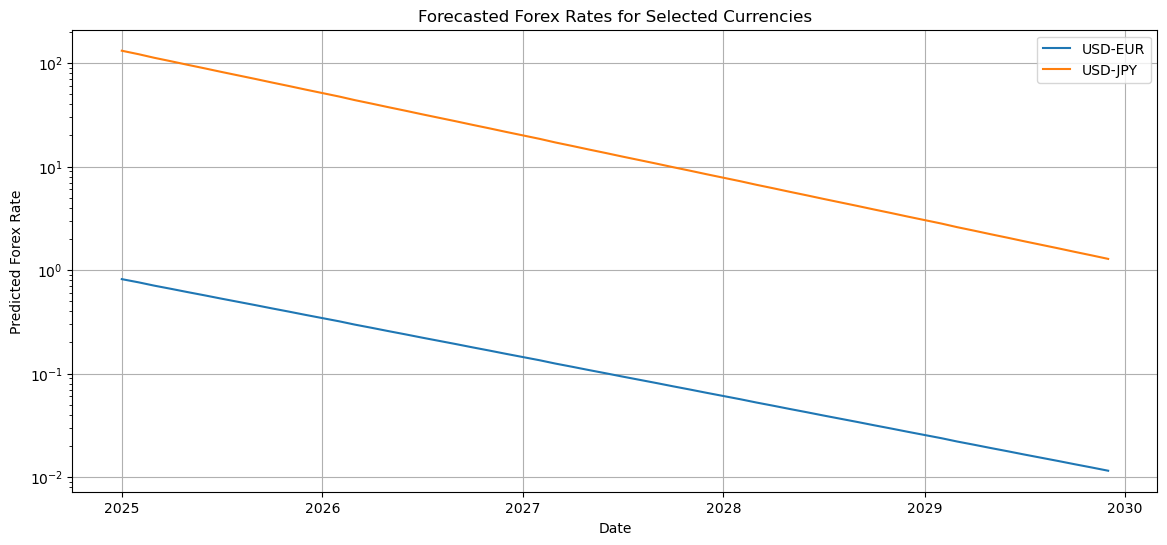

In [24]:
import matplotlib.pyplot as plt

# Plot future predictions for each currency
plt.figure(figsize=(14, 6))

for currency in ['USD-EUR', 'USD-JPY']:
    df = future_predictions[future_predictions['Currency'] == currency]
    plt.plot(df['DATE'], df['Predicted_Forex_Rate'], label=currency)

plt.yscale('log')
plt.title("Forecasted Forex Rates for Selected Currencies")
plt.xlabel("Date")
plt.ylabel("Predicted Forex Rate")
plt.legend()
plt.grid(True)
plt.show()


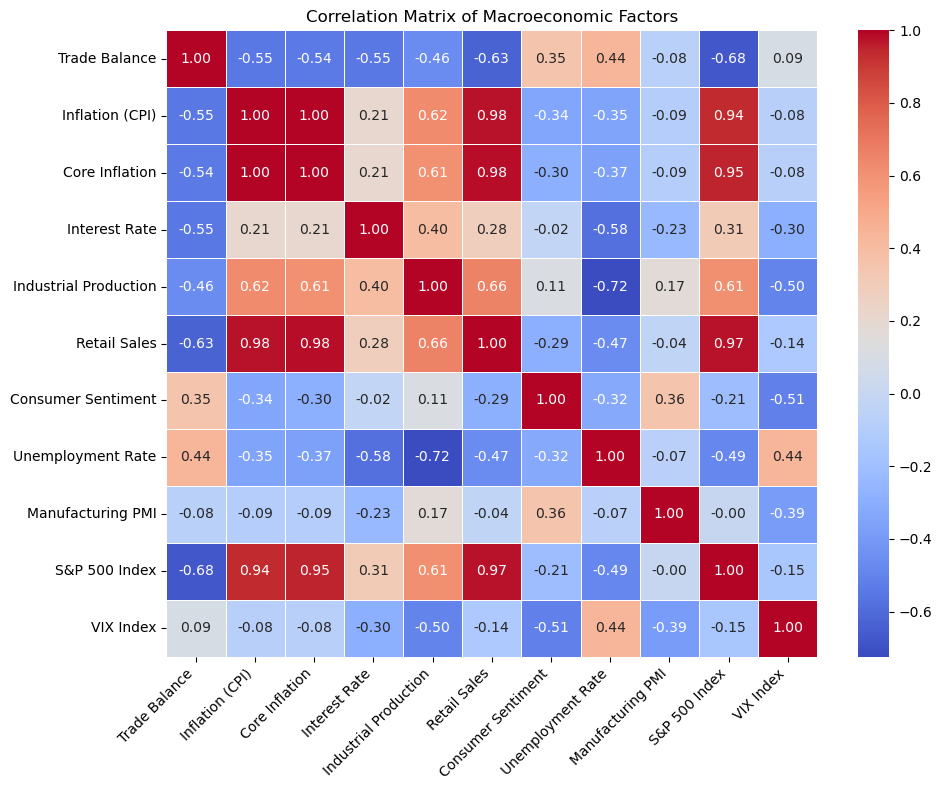

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your macro data
macro = pd.read_csv("macro_data.csv", parse_dates=["DATE"]).set_index("DATE")

# Just remove 'DATE' from columns — we only care about macro variables
macro_variables = macro.dropna()  # drop missing rows if any

# Calculate correlation matrix
macro_corr = macro_variables.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(macro_corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Macroeconomic Factors")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
with tab6:
    st.markdown("## Scenario Simulator")
    st.write("Simulate hypothetical changes in U.S. macro variables and forecast FX rates over 5, 7, or 10 years.")

    # --- User Selections ---
    st.markdown("### 1. Select Forecast Settings")

    # Allow multiple currency selection
    currency_options = ["USD-EUR", "USD-JPY", "USD-GBP", "USD-CHF", "USD-CAD", "USD-AUD", "USD-NZD", "USD-CNY", "USD-HKD", "USD-XAU"]
    selected_currencies = st.multiselect("Select Currency Pairs", options=currency_options, default=["USD-EUR"])

    # Select macroeconomic factors
    macro_options = [
    'Interest Rate',
    'Inflation (CPI)',
    'Core Inflation',
    'Industrial Production',
    'Trade Balance',
    'Unemployment Rate',
    'Consumer Sentiment',
    'Retail Sales',
    'Manufacturing PMI',
    'S&P 500 Index',
    'VIX Index'
]
    selected_macros = st.multiselect("Select Macroeconomic Indicators", options=macro_options, default=['Interest Rate', 'Inflation (CPI)'])

    # Select model
    model_choice = st.selectbox("Select Model", ["OLS", "Lasso", "XGBoost"])

    # Select forecast horizon
    forecast_years = st.selectbox("Select Forecast Horizon (Years)", options=[5, 7, 10], index=0)

    st.markdown("---")
    st.markdown("### 2. Adjust Macroeconomic Scenario")

    # Dynamic sliders for each selected macro
    macro_adjustments = {}
    for macro in selected_macros:
        adj = st.slider(f"Adjust {macro} (%)", -5.0, 5.0, 0.5, step=0.1)
        macro_adjustments[macro] = adj

    st.markdown("---")

    # --- Run Simulation Button ---
    if st.button("Run Simulation"):

        from run_forex_model import run_forex_model

        real_metrics, future_predictions = run_forex_model(
            selected_currencies=selected_currencies,
            selected_macros=selected_macros,
            selected_model=model_choice,
            macro_adjustments=macro_adjustments,
            future_years=forecast_years
        )

        # --- Display Test Set Model Performance ---
        st.markdown("### Model Performance on Real 2023–2025 Data")
        st.dataframe(real_metrics)

        # --- Plot Forecasts ---
        st.markdown(f"### Forecasted Forex Rates for Next {forecast_years} Years")

        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(figsize=(8, 2))
        for currency in selected_currencies:
            df = future_predictions[future_predictions['Currency'] == currency]
            ax.plot(df['DATE'], df['Predicted_Forex_Rate'], label=currency)

        ax.set_title("Forecasted Forex Rates (Log Scale)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Predicted Forex Rate")
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        st.pyplot(fig)

        st.markdown("### Correlation Matrix of Selected Macroeconomic Indicators")

        # --- Load macro data ---
        macro_raw = pd.read_csv("macro_data.csv", parse_dates=["DATE"]).set_index("DATE")
        
        # --- Select only macros the user selected ---
        # Assuming selected_macros already exists from your earlier multiselect
        macro_selected = macro_raw[selected_macros].dropna()
        
        # --- Calculate correlation matrix ---
        macro_corr_matrix = macro_selected.corr()
        
        # --- Plot correlation heatmap ---
        import seaborn as sns
        import matplotlib.pyplot as plt
        
        fig4, ax4 = plt.subplots(figsize=(2, 1))
        sns.heatmap(macro_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, ax=ax4)
        ax4.set_title("Correlation of Selected Macroeconomic Factors")
        ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
        ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0)
        st.pyplot(fig4)
